<a href="https://colab.research.google.com/github/NVIDIA/DeepLearningExamples/tree/master/TensorFlow/Segmentation/UNet_Industrial/notebooks/Colab_UNet_Industrial_TF_TFHub_export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# UNet Industrial Demo on TensorFLow Hub: Export and Inference

## Overview


In this notebook, we will demo the process of exporting NVIDIA NGC [Unet Industrial defects detection models](https://ngc.nvidia.com/catalog/model-scripts/nvidia:unet_industrial_for_tensorflow)  to TF-Hub modules, which can be persisted to disk, saved to a Google Drive folder or published on to TF-Hub. NVIDIA pre-trained U-Net model is adapted from the original version of the [U-Net model](https://arxiv.org/abs/1505.04597) which is
a convolutional auto-encoder for 2D image segmentation. U-Net was first introduced by
Olaf Ronneberger, Philip Fischer, and Thomas Brox in the paper:
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).

[NVIDIA NGC](https://ngc.nvidia.com/catalog/models) is the hub for GPU-optimized software and pre-trained models for deep learning, machine learning, and HPC that takes care of all the plumbing so data scientists, developers, and researchers can focus on building solutions, gathering insights, and delivering business value.

[TensorFlow Hub](https://www.tensorflow.org/hub) is "a library for the publication, discovery, and consumption of reusable parts of machine learning models. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning."



### Requirement
1. Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.



In [1]:
!nvidia-smi

Mon Oct 28 23:39:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

The below code checks whether a Tensor-Core GPU is present.  Tensor Cores can accelerate large matrix operations by performing mixed-precision matrix multiply and accumulate calculations in a single operation. 

In [2]:
%tensorflow_version 1.x  
import tensorflow as tf
print(tf.__version__)  # This notebook runs on TensorFlow 1.x. 

from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

1.15.0
Tensor Core GPU Present: None


2. Next, we clone the NVIDIA Github UNet Industrial repository and set up the workspace.

In [3]:
!git clone https://github.com/NVIDIA/DeepLearningExamples

Cloning into 'DeepLearningExamples'...
remote: Enumerating objects: 4151, done.
remote: Total 4151 (delta 0), reused 0 (delta 0), pack-reused 4151
Receiving objects: 100% (4151/4151), 32.36 MiB | 25.80 MiB/s, done.
Resolving deltas: 100% (1858/1858), done.


In [4]:
%%bash
cd DeepLearningExamples
git checkout master

Your branch is up to date with 'origin/master'.


Already on 'master'


In [5]:
import os

WORKSPACE_DIR='/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks'
os.chdir(WORKSPACE_DIR)
print (os.getcwd())

/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks


In [6]:
!pip install tensorflow_hub==0.6.0

## Data download

We will first download some data for testing, in particular, the [Weakly Supervised Learning for Industrial Optical Inspection (DAGM 2007)](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html) competition dataset. 

> The competition is inspired by problems from industrial image processing. In order to satisfy their customers' needs, companies have to guarantee the quality of their products, which can often be achieved only by inspection of the finished product. Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.
>
> The competitors have to design a stand-alone algorithm which is able to detect miscellaneous defects on various background textures.
>
> The particular challenge of this contest is that the algorithm must learn, without human intervention, to discern defects automatically from a weakly labeled (i.e., labels are not exact to the pixel level) training set, the exact characteristics of which are unknown at development time. During the competition, the programs have to be trained on new data without any human guidance.

**Source:** https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html


In [0]:
! ./download_and_preprocess_dagm2007_public.sh ./data

The final data directory should look like:

```
./data
  raw_images
      public
          Class1	    
          Class2	
          Class3	    
          Class4	
          Class5	    
          Class6
          Class1_def  
          Class2_def	
          Class3_def  
          Class4_def	
          Class5_def  
          Class6_def
      private
  zip_files
```

Each data directory contains training images corresponding to one of 6 types of defects.

## Model download from NVIDIA NGC model repository

NVIDIA provides pretrained UNet models along with many other deep learning models such as ResNet, BERT, Transformer, SSD... at https://ngc.nvidia.com/catalog/models. Here, we will download and unzip pretrained UNet models corresponding to the 10 classes of the DAGM 2007 defects detection dataset. 

In [0]:
%%bash
rm unet_model.zip
wget -nc -q --show-progress -O unet_model.zip \
"https://api.ngc.nvidia.com/v2/models/nvidia/unetindustrial_for_tensorflow_32/versions/1/zip"
unzip -o ./unet_model.zip

Upon completion of the download, the following model directories should exist, containing pre-trained models corresponding to the 10 classes of the DAGM 2007 competition data set.

In [10]:
!ls JoC_UNET_Industrial_FP32_TF_20190522

Class+1   Class+2  Class+4  Class+6  Class+8
Class+10  Class+3  Class+5  Class+7  Class+9


## Inference with Native TensorFlow

We will now launch an interactive sesssion to verify the correctness of the pretrained models, where you can load new test images. First, we load some required libraries and define some helper functions to load the pretrained UNet models.

In [11]:
!pip install ../dllogger 

Processing /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/dllogger
  Created wheel for DLLogger: filename=DLLogger-0.3.1-cp36-none-any.whl size=9884 sha256=d55727ea0a3d128257a57d137b278ace7f076fc07e128cb49d07bbe8c4a97b5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-l4bzc15k/wheels/23/a4/72/2606d992c53ecdd7969c79ed3fb0c23dacdbdb438a8c17999a
Successfully built DLLogger


In [0]:
import dllogger
from dllogger.logger import LOGGER

In [12]:
try:
    __import__("horovod")
except ImportError:
    os.system("pip install horovod")

import horovod.tensorflow
import sys

sys.path.insert(0,'/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial')
from model.unet import UNet_v1

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

We will now load and inspect one defect image from Class 1.

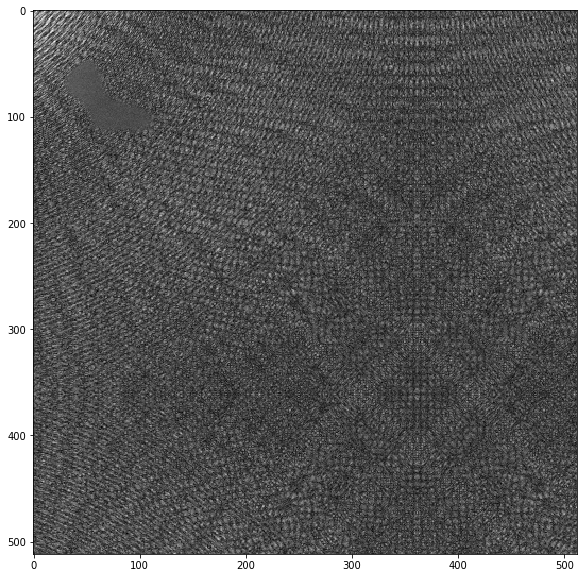

In [14]:
img = mpimg.imread('./data/raw_images/public/Class1_def/1.png')

plt.figure(figsize = (10,10));
plt.imshow(img, cmap='gray');

As we can see in this figure, there exists a defective area in the top left corner. We will now load the model and carry out inference on the normalized test image.

In [0]:
# Image preprocessing
img =  np.expand_dims(img, axis=2)
img =  np.expand_dims(img, axis=0)
img = (img-0.5)/0.5

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500")
        
        
        output = sess.run([outputs, logits], feed_dict={tf_input: img})
        


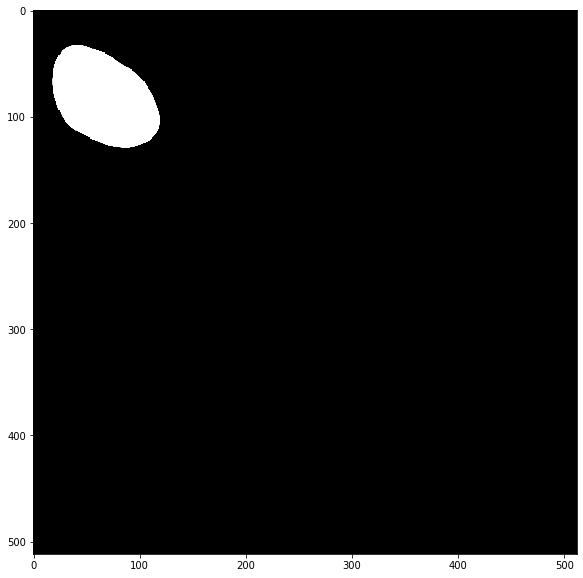

In [21]:
# Print out model predicted mask
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

As expected, the model points out the correct defective area in this image. Please feel free to try out other defective images for Class 1 within `./data/raw_images/public/Class1_def/`, or load the model and test data for other classes from 1 to 10. 

In [22]:
!ls ./data/raw_images/public/Class1_def/

100.png  116.png  131.png  147.png  26.png  41.png  57.png  72.png  88.png
101.png  117.png  132.png  148.png  27.png  42.png  58.png  73.png  89.png
102.png  118.png  133.png  149.png  28.png  43.png  59.png  74.png  8.png
103.png  119.png  134.png  14.png   29.png  44.png  5.png   75.png  90.png
104.png  11.png   135.png  150.png  2.png   45.png  60.png  76.png  91.png
105.png  120.png  136.png  15.png   30.png  46.png  61.png  77.png  92.png
106.png  121.png  137.png  16.png   31.png  47.png  62.png  78.png  93.png
107.png  122.png  138.png  17.png   32.png  48.png  63.png  79.png  94.png
108.png  123.png  139.png  18.png   33.png  49.png  64.png  7.png   95.png
109.png  124.png  13.png   19.png   34.png  4.png   65.png  80.png  96.png
10.png	 125.png  140.png  1.png    35.png  50.png  66.png  81.png  97.png
110.png  126.png  141.png  20.png   36.png  51.png  67.png  82.png  98.png
111.png  127.png  142.png  21.png   37.png  52.png  68.png  83.png  99.png
112.png  128.png  143.png  

## Export UNet models to TF-Hub

We will now export the 10 pretrained UNet models into TensorFlow hub modules.

In [0]:
def module_fn(is_training=False):
    """A module_fn for use with hub.create_module_spec().
    Args:
      is_training: a boolean  meant to control whether batch norm, dropout etc. 
      are built in training or inference mode for this graph version (TODO)

    """
    # Set up the module input
    with tf.name_scope('hub_input'):
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
    # Build the net.
    network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
    outputs, logits = network.build_model(tf_input)
    
 
    # Add the default signature.
    hub.add_signature('default', dict(images=tf_input), dict(default=outputs))
    

In [0]:
import tensorflow_hub as hub

tags_and_args = [
    # The default graph is built with batch_norm, dropout etc. in inference
    # mode. This graph version is good for inference, not training.
    ([], {
        'is_training': False
    }),
    # A separate 'train' graph builds batch_norm, dropout etc. in training
    # mode.
    (['train'], {
        'is_training': True  # TODO
    }),
]
drop_collections = [
    'moving_vars', tf.GraphKeys.GLOBAL_STEP,
    tf.GraphKeys.MOVING_AVERAGE_VARIABLES
]
spec = hub.create_module_spec(module_fn, tags_and_args, drop_collections)

In [25]:
for class_id in range (1, 11):    
  with tf.Graph().as_default():
    module = hub.Module(spec)
    variables_to_restore = module.variable_map
    init_fn = tf.contrib.framework.assign_from_checkpoint_fn(model_path="JoC_UNET_Industrial_FP32_TF_20190522/Class+%d/model.ckpt-2500"%class_id,
                                                             var_list=variables_to_restore)
    with tf.Session() as session:
      init_fn(session)
      module.export("./NVIDIA/Unet/Class_%d/"%class_id, session=session)


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500
INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+2/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+2/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+3/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+3/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+4/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+4/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+5/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+5/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+6/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+6/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+7/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+7/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+8/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+8/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+9/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+9/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500


INFO:tensorflow:Restoring parameters from JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500


## Save TF-Hub modules to Google Drive (Optional)

In this step we will persist the created TF-Hub modules to Google Drive. Execute the below cell to authorize Colab to access your Google Drive content, then copy the created UNet TF-Hub modules to Google Drive.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
!cp -r "./NVIDIA" "/content/gdrive/My Drive/"

## Inference with TF-Hub modules

Next, we will load and do inference with the created TensorFlow Hub modules. In order to load TF Hub modules, there are several options:

- Load from a local cache or directory

- Load from a remote repository



In [0]:
import tensorflow_hub as hub

# Loading from a local cache/directory
#module = hub.Module("NVIDIA/Unet/Class_1", trainable=False)

# Loading from a remote repository. The 10 NVIDIA UNet TF-Hub modules are available at
# https://tfhub.dev/nvidia/unet/industrial/class_1/1 (similarly for class 2, 3 ...) and
# https://developer.download.nvidia.com/compute/redist/Binary_Files/unet_tfhub_modules/class_{1..10}

module = hub.Module("https://tfhub.dev/nvidia/unet/industrial/class_1/1")  # or class_2, class_3 etc...
#module = hub.Module("https://developer.download.nvidia.com/compute/redist/Binary_Files/unet_tfhub_modules/class_1/1.tar.gz")  # or class_2, class_3 etc...

In [27]:
print(module.get_signature_names())

['default']


In [28]:
print(module.get_input_info_dict())   # When no signature is given, considers it as 'default'


{'images': <hub.ParsedTensorInfo shape=(?, 512, 512, 1) dtype=float32 is_sparse=False>}


In [29]:
print(module.get_output_info_dict())

{'default': <hub.ParsedTensorInfo shape=(?, 512, 512, 1) dtype=float32 is_sparse=False>}


In [0]:
# Load a test image
img = mpimg.imread('./data/raw_images/public/Class1_def/1.png')

# Image preprocessing
img =  np.expand_dims(img, axis=2)
img =  np.expand_dims(img, axis=0)
img = (img-0.5)/0.5

In [31]:
 with tf.Session() as sess:
    output = module(img)
    sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
    pred = sess.run(output)
      

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


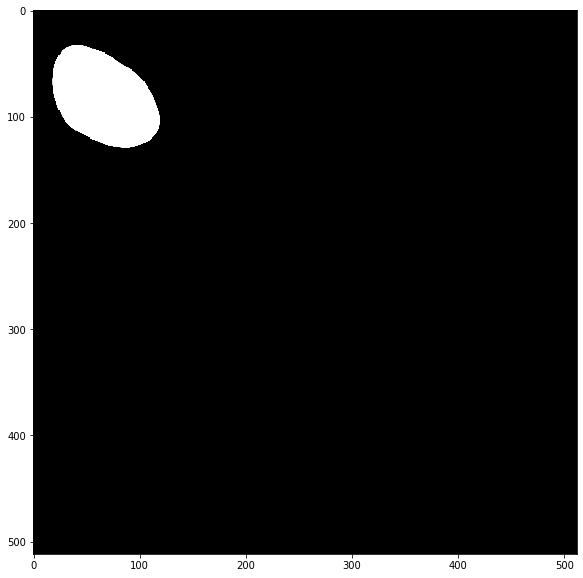

In [32]:
# Print out model predicted mask
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(pred), cmap='gray')

# Conclusion

In this notebook, we have walked through the complete process of creating TF-Hub modules from pretrained UNet-Industrial models, then test the correctness of the created TF-Hub modules.
## What's next
Now it's time to try the UNet-Industrial TensorFlow Hub modules on your own data. 